# QPM Assignement 4 - MVP and GMV portfolios with no constraints

by Guillaume IDAME KORALAGE

## Librairies

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize

## Functions

In [2]:
#Market Data
def get_market_data(list_yahoo_codes, start_date, end_date) : 
    market_data = yf.download(list_yahoo_codes, start = start_date, end = end_date)
    return market_data

In [121]:
#MVP - Mean Variance Portfolio
def mv_objective(weights, mu, V, gamma, Rf):
    
    ones = np.ones((len(mu), 1))
    portfolio_return = weights.T @ (mu - Rf * ones)
    portfolio_risk = weights.T @ V @ weights
    
    return (gamma/2) * portfolio_risk - portfolio_return

def get_mv_weights(mu, V, gamma, Rf) :
    
    ones = np.ones((len(mu), 1))
    initial_weights = np.ones(len(mu))/len(mu)
    
    result = minimize(mv_objective, initial_weights, args = (mu, V, gamma, Rf, ), method='SLSQP')
    w_mv = result.x
    
    w_riskFree = 1 - ones.T @ w_mv
    w_tangency = w_mv / (ones.T @ w_mv)
    
    return w_tangency

def get_mv_portfolio_return(log_return, gamma, Rf) :
    
    mu = np.array(log_return.mean()).reshape(-1,1)
    V = np.array(log_return.cov())
    w_tangency = get_mv_weights(mu, V, gamma, Rf)
    breakdown_portfolio_return = w_tangency * log_return
    portfolio_return = breakdown_portfolio_return.sum(axis = 1)
    
    return portfolio_return

def get_rolling_mv_weights(monthly_log_return, gamma, Rf, window):
    
    dict_mv_w_tangency = {}
    for t in range(window, len(monthly_log_return), window) :

        df_train = monthly_log_return.iloc[t - window : t, :]
        mu = np.array(df_train.mean()).reshape(-1,1)
        V = np.array(df_train.cov())
        mv_w_tangency = get_mv_weights(mu, V, gamma, Rf)

        rebal_date = monthly_log_return.index[t+1]

        dict_mv_w_tangency[t] = pd.DataFrame(mv_w_tangency, index = df_train.columns, columns = [rebal_date]).T
    
    rolling_mv_w_tangency = pd.concat(dict_mv_w_tangency.values())
    
    return rolling_mv_w_tangency

In [122]:
#GMV (Global Minimum Value)
def gmv_objective(weights, V):
    portfolio_variance = weights.T @ V @ weights
    return portfolio_variance

def get_gmv_weights(V) :
    
    ones = np.ones((len(V), 1))
    initial_weights = np.ones(len(V))/len(V)
    
    result = minimize(gmv_objective, initial_weights, args = (V, ), method='SLSQP')
    w_gmv = result.x
    
    w_riskFree = 1 - ones.T @ w_gmv
    w_tangency = w_gmv / (ones.T @ w_gmv)
    
    return w_tangency

def get_gmv_portfolio_return(log_return) :
    
    V = np.array(log_return.cov())
    w_tangency = get_gmv_weights(V)
    breakdown_portfolio_return = w_tangency * log_return
    portfolio_return = breakdown_portfolio_return.sum(axis = 1)
    
    return portfolio_return

def get_rolling_gmv_weights(monthly_log_return, window):

    dict_gmv_w_tangency = {}
    for t in range(window, len(monthly_log_return), window) :

        df_train = monthly_log_return.iloc[t - window : t, :]
        V = np.array(df_train.cov())
        gmv_w_tangency = get_gmv_weights(V)
        
        rebal_date = monthly_log_return.index[t+1]
        
        dict_gmv_w_tangency[t] = pd.DataFrame(gmv_w_tangency, index = df_train.columns, columns = [rebal_date]).T
        
    rolling_gmv_w_tangency = pd.concat(dict_gmv_w_tangency.values())

    return rolling_gmv_w_tangency

## Assignement 

#### Q4.0 From the data that we used for the previous assignment, select the following 10 companies (these are the first 10 companies with no missing data): "MMM","AOS","ABT","ADM","ADBE","ADP","AES","AFL","A","AKAM"
- So, our new dataset for this assignment will consist of monthly returns you had computed in the last assignment, but just for these 10 companies.
- To reduce the work required for this assignment, please assume that the risk-free rate of return is zero.

In [179]:
list_yahoo_codes = ["MMM","AOS","ABT","ADM","ADBE","ADP","AES","AFL","A","AKAM"]
start_date = "2000-01-01"
end_date = "2022-12-31"

In [180]:
market_data = get_market_data(list_yahoo_codes, start_date, end_date) 
close_price_data = market_data.xs("Adj Close", level = 0, axis = 1)
clean_close_price_data = close_price_data.dropna(how = "all", axis = 1)
clean_close_price_data.tail()

[*********************100%%**********************]  10 of 10 completed


,A,ABT,ADBE,ADM,ADP,AES,AFL,AKAM,AOS,MMM
Date,,,,,,,,,,
2022-12-23,148.183105,106.058311,338.450012,92.479225,235.585602,27.770977,70.109047,83.160004,55.871155,113.290993
2022-12-27,148.500885,106.440659,335.089996,93.740051,235.673584,27.906540,70.587837,83.500000,56.627224,113.366432
2022-12-28,147.051102,105.715172,328.329987,91.501854,232.564255,27.422388,69.835449,83.500000,55.743507,111.546455
2022-12-29,150.030060,108.146538,337.579987,91.013176,235.272705,27.896856,70.431496,84.699997,56.617413,113.696472
2022-12-30,148.821777,107.636734,336.529999,90.749268,233.551819,27.848444,70.294701,84.300003,56.205006,113.083534


#### Q4.1 Choose the estimation window to be Test = 60 months of monthly returns. Call this the estimation sample. Use the estimation sample to compute the following two portfolio strategies:
- a. mean-variance portfolio (MVP) without constraints on the size of the weight (assume that a risk-free rate is available, with the risk-free rate equal to zero);
- b. global minimum variance (GMV) portfolio without constraints on the size of the weight.

In [181]:
daily_log_return = np.log(clean_close_price_data / clean_close_price_data.shift(1)).dropna()

sample_clean_close_price_data = clean_close_price_data.resample("6M").last().dropna()
sample_log_return = np.log(sample_clean_close_price_data / sample_clean_close_price_data.shift(1)).dropna()

gamma = 5
Rf = 0

window = 60
t = window

In [182]:
#MV Portfolio
df_train = sample_log_return.iloc[t - window : t, :]
mu = np.array(df_train.mean()).reshape(-1,1)
V = np.array(df_train.cov())
mv_w_tangency = get_mv_weights(mu, V, gamma, Rf)
rebal_date = daily_log_return.index[t+1]
mv_w_tangency_data = pd.DataFrame(mv_w_tangency, index = df_train.columns, columns = [rebal_date]).T

mv_breakdown_return = mv_w_tangency_data.reindex(daily_log_return.index).ffill() * daily_log_return.iloc[t+1 : ,:]
mv_return = mv_breakdown_return.sum(axis = 1)
mv_breakdown_cumul_return = (1 + mv_breakdown_return).cumprod() - 1

In [183]:
#GMV Portfolio
df_train = sample_log_return.iloc[t - window : t, :]
V = np.array(df_train.cov())
gmv_w_tangency = get_gmv_weights(V)
rebal_date = daily_log_return.index[t+1]
gmv_w_tangency_data = pd.DataFrame(gmv_w_tangency, index = df_train.columns, columns = [rebal_date]).T

gmv_breakdown_return = gmv_w_tangency_data.reindex(daily_log_return.index).ffill() * daily_log_return.iloc[t+1 : ,:]
gmv_return = gmv_breakdown_return.sum(axis = 1)
gmv_breakdown_cumul_return = (1 + gmv_breakdown_return).cumprod() - 1

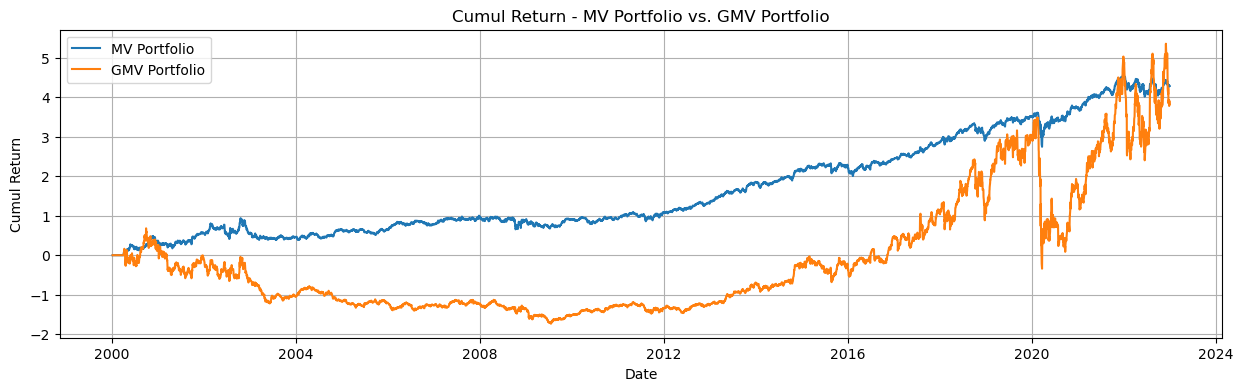

In [184]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(mv_breakdown_cumul_return.sum(axis = 1), label = "MV Portfolio")
ax.plot(gmv_breakdown_cumul_return.sum(axis = 1), label = "GMV Portfolio")
ax.set_title("Cumul Return - MV Portfolio vs. GMV Portfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Cumul Return")
ax.legend()
ax.grid()

In [185]:
portfolios_strategies = pd.concat([mv_return, gmv_return], keys = ["MVP", "GMV"], axis = 1)

In [186]:
metrics = pd.DataFrame()
metrics["Ann. Return"] = portfolios_strategies.mean() * 252
metrics["Ann. Vol"] = portfolios_strategies.std() * np.sqrt(252)
metrics["Ann. Sharpe"] = metrics["Ann. Return"] / metrics["Ann. Vol"]
metrics

,Ann. Return,Ann. Vol,Ann. Sharpe
MVP,0.144150,0.226473,0.636498
GMV,0.055746,0.458262,0.121646


#### Q4.2 Now use a rolling window of Test = 60 months to estimate the portfolio weights for the two strategies listed above for each of the T Test months. That is, repeat the calculations of the previous question for all the dates after the first 60 months.

In [187]:
log_return = np.log(clean_close_price_data / clean_close_price_data.shift(1)).dropna()
gamma = 5
Rf = 0

In [188]:
window = 60

In [189]:
#MV Portfolios
rolling_mv_w_tangency = get_rolling_mv_weights(log_return, gamma, Rf, window)
rolling_mv_w_tangency.head()

,A,ABT,ADBE,ADM,ADP,AES,AFL,AKAM,AOS,MMM
2000-03-31,-0.159336,0.114276,-0.401468,0.425912,0.002679,-0.317901,0.176594,0.362755,0.565323,0.231165
2000-06-27,-0.131025,0.661345,0.233162,-0.273204,0.942652,0.264767,-0.043197,-0.181592,0.196810,-0.669717
2000-09-21,-0.056409,0.160209,0.239454,-0.249020,0.537337,0.212363,0.498195,-0.100033,-0.675054,0.432958
2000-12-15,0.022990,0.031700,-0.024649,0.272869,0.006519,-0.085083,0.109818,-0.012501,0.448121,0.230216
2001-03-15,-0.317652,0.226276,-0.949527,2.567831,-0.847337,-0.646798,-2.716441,-0.941767,7.339901,-2.714487


In [190]:
#GMV Portfolio
rolling_gmv_w_tangency = get_rolling_gmv_weights(log_return, window)
rolling_gmv_w_tangency.head()

,A,ABT,ADBE,ADM,ADP,AES,AFL,AKAM,AOS,MMM
2000-03-31,0.106399,0.764153,-0.145817,0.332567,-0.290960,-0.873422,0.129243,-0.138794,1.257892,-0.141261
2000-06-27,-0.137751,0.227377,0.085284,-0.680830,-0.080165,-0.372801,0.019040,0.067286,1.322385,0.550173
2000-09-21,-0.087775,-0.054872,0.144123,0.240256,0.346217,-0.068690,0.065977,0.073299,-0.212343,0.553808
2000-12-15,0.083203,0.062646,-0.025003,0.108639,0.362770,-0.229702,-0.018390,0.035858,0.515763,0.104214
2001-03-15,-0.088911,0.057649,0.114444,-0.218923,0.286517,-0.231695,-0.067682,-0.115086,1.033119,0.230566


#### Q4.3 Use the time-series of portfolios weights for each of the two portfolio strategies, to compute the out-of-sample portfolio returns. That is, for each of the two portfolio strategies that you estimate at each date t, compute its out-of-sample return in month t + 1.

In [191]:
#MV Return
rolling_mv_breakdown_return = rolling_mv_w_tangency.reindex(log_return.index).ffill() * log_return 
rolling_mv_breakdown_cumul_return = (1 + rolling_mv_breakdown_return.dropna()).cumprod() - 1

rolling_mv_return = rolling_mv_breakdown_return.dropna().sum(axis = 1)
rolling_mv_cumul_return = (1 + rolling_mv_return.dropna()).cumprod() - 1

#GMV Return
rolling_gmv_breakdown_return = rolling_gmv_w_tangency.reindex(log_return.index).ffill() * log_return 
rolling_gmv_breakdown_cumul_return = (1 + rolling_gmv_breakdown_return.dropna()).cumprod() - 1

rolling_gmv_return = rolling_gmv_breakdown_return.dropna().sum(axis = 1)
rolling_gmv_cumul_return = rolling_gmv_breakdown_cumul_return.sum(axis=1)

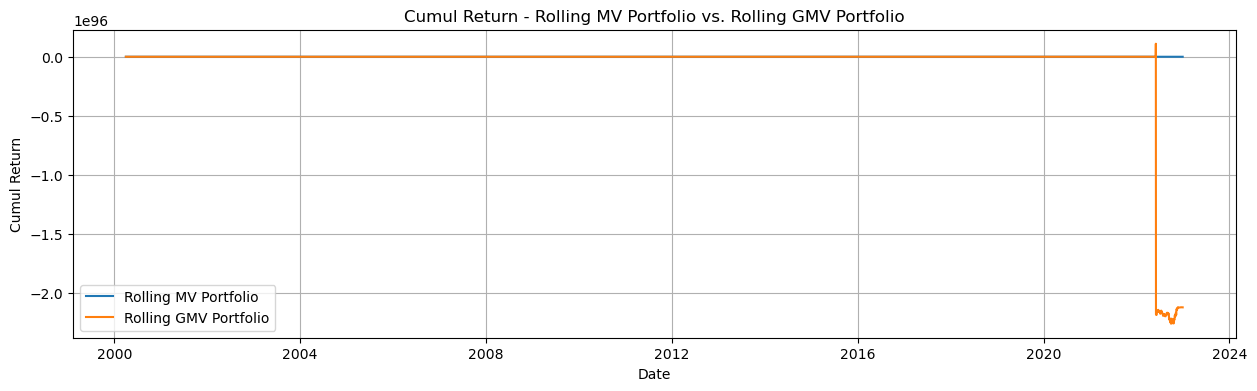

In [192]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(rolling_mv_cumul_return, label = "Rolling MV Portfolio")
ax.plot(rolling_gmv_cumul_return, label = "Rolling GMV Portfolio")
ax.set_title("Cumul Return - Rolling MV Portfolio vs. Rolling GMV Portfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Cumul Return")
ax.legend()
ax.grid()

#### Q4.4 Now, compute the Sharpe ratio of the out-of-sample returns for the two portfolio strategies. Which strategy has the higher Sharpe ratio?

In [137]:
rolling_portfolios_strategies = pd.concat([rolling_mv_return, rolling_gmv_return], keys = ["Rolling MVP", "Rolling GMV"], axis = 1)

In [138]:
rolling_metrics = pd.DataFrame()
rolling_metrics["Ann. Return"] = rolling_portfolios_strategies.mean() * 252
rolling_metrics["Ann. Vol"] = rolling_portfolios_strategies.std() * np.sqrt(252)
rolling_metrics["Ann. Sharpe"] = rolling_metrics["Ann. Return"] / rolling_metrics["Ann. Vol"]
rolling_metrics

,Ann. Return,Ann. Vol,Ann. Sharpe
Rolling MVP,1.229476,5.091518,0.241475
Rolling GMV,0.337250,0.720523,0.468063


In [ ]:
import numpy as np
import pandas as pd
#import warnings
#warnings.filterwarnings("ignore")

from random import gauss, randint
from scipy.optimize import minimize, NonlinearConstraint
from scipy.sparse.construct import rand

class PortfolioOptimization(object):
    def __init__(self, number_of_constituents, ineq_constraints):
        self.ineq_constraints   = ineq_constraints
        self.num_const          = number_of_constituents
        self.returns_const      = pd.DataFrame([self.generate_random_returns() for i in range(self.num_const)]).T #20 constituents
        self.returns_objective  = pd.DataFrame(self.generate_random_returns(), columns=["portfolio_to_estimate"])

    def generate_inequality_constraints(self, inequality_constraints, number_of_constituents):
        constraints         = []
        for key in inequality_constraints.keys():
            min_weight      = inequality_constraints[key]
            n_smallest_temp = int(number_of_constituents*key)
            temp_constraint = {"type": "ineq", "fun": lambda x: sum(sorted(x)[:n_smallest_temp])-min_weight}
            constraints.append(temp_constraint)
        return constraints

    def generate_nonlinear_constraints(self, inequality_constraints, number_of_constituents):
        constraints         = []
        for key in inequality_constraints.keys():
            min_weight      = inequality_constraints[key]
            n_smallest_temp = int(number_of_constituents*key)
            temp_constraint = NonlinearConstraint(fun=lambda x: sum(sorted(x)[:n_smallest_temp]), lb=min_weight, ub=1, keep_feasible=True)
            constraints.append(temp_constraint)
        return constraints

    def check_inequality_constraints(self, weights_dict):
        ineq_constraints    = self.ineq_constraints
        weights_dict        = {k: v for k, v in sorted(weights_dict.items(), reverse=True, key=lambda item: item[1])}
        for key in ineq_constraints.keys():
            min_weight      = ineq_constraints[key]
            n_smallest_temp = int(self.num_const*key)
            weight_n_small  = sum(list(weights_dict.values())[-n_smallest_temp:])
            if weight_n_small<min_weight:
                print(f"Concentration constraint not fulfilled. Smallest {key*100}% have weight of {weight_n_small} (<{min_weight})")
            else:
                print(f"Smallest {key*100}% have weight of {weight_n_small} (>{min_weight})")

    def generate_random_returns(self, mean=0.015, volatility=0.03, datapoints=200):
        #rand_inte       = randint(1,10)/10
        random_numbers  = [gauss(mean, volatility) for i in range(datapoints)]
        return random_numbers

    def correlation_portfolio(self, weights):
        #weights_dict        = {key: value for key, value in zip(range(self.num_const), weights)}
        #self.check_inequality_constraints(weights_dict)
        portfolio_returns   = pd.concat([np.sum(self.returns_const*weights, axis=1), self.returns_objective], axis=1)
        portfolio_returns.rename(columns={0: 'portfolio_returns'}, inplace=True)

        correlations    = portfolio_returns.corr()
        correlation     = correlations["portfolio_returns"].loc["portfolio_to_estimate"]
        #print(correlation)
        return -correlation

    def portfolio_optimization(self, ineq_constraints, non_linear_constraints=False):
        bounds              = self.num_const *[(0,1)] #20 constituents, min weight 0, max weight 1
        x0                  = self.num_const *[1/self.num_const ]

        if non_linear_constraints:
            constraints     = self.generate_nonlinear_constraints(inequality_constraints=ineq_constraints, number_of_constituents=number_of_const)
        else:
            constraints     = self.generate_inequality_constraints(inequality_constraints=ineq_constraints, number_of_constituents=number_of_const)
        constraints         = [{"type": "eq", "fun": lambda x: np.sum(x)-1}]+constraints #weights add up to 1
        constraints         = constraints+[{"type": "ineq", "fun": lambda x: np.sum([el for el in x if el<0.05])-0.5}] #sum of all weights bigger than 0.05 is smaller than 0.5

        optimum             = minimize(self.correlation_portfolio, x0=x0, bounds=bounds, options={"disp": False}, constraints=constraints).x
        weights_dict        = {key: value for key, value in zip(range(self.num_const), optimum)}
        self.check_inequality_constraints(weights_dict)
        return weights_dict

ineq_constraints= {0.25: 0.1, 0.5: 0.25, 0.75: 0.5, 0.9: 0.3} #smallest 25% need to have at least 10% weight, 50% smallest need to have at least 25% weight and 75% smallest need to have at least 50% weight
number_of_const = 30

pf_optim        = PortfolioOptimization(number_of_constituents=number_of_const, ineq_constraints=ineq_constraints)
weights_dict    = pf_optim.portfolio_optimization(ineq_constraints=ineq_constraints)
weights_dict    = pf_optim.portfolio_optimization(ineq_constraints=ineq_constraints, non_linear_constraints=True)